In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gerrychain import Graph, Partition, GeographicPartition, updaters
from gerrychain.updaters import Tally, cut_edges
from gingleator import Gingleator

In [2]:
# Load the graph
graph = Graph.from_json("./VA/VA1.json")

In [3]:
# Fix missing fields
for node in graph.nodes:
    graph.nodes[node]["TOTPOP"] = graph.nodes[node].get("TOTPOP", 0) or 0
    graph.nodes[node]["VAP"] = graph.nodes[node].get("VAP", 1) or 1  # to avoid zero division
    graph.nodes[node]["BVAP"] = graph.nodes[node].get("BVAP", 0) or 0
    graph.nodes[node]["HVAP"] = graph.nodes[node].get("HVAP", 0) or 0
    graph.nodes[node]["ASIANVAP"] = graph.nodes[node].get("ASIANVAP", 0) or 0

    graph.nodes[node]["CombinedVAP"] = (
        graph.nodes[node]["BVAP"] +
        graph.nodes[node]["HVAP"] +
        graph.nodes[node]["ASIANVAP"]
    )

In [4]:
# Set Updaters
updaters_dict = {
    "population": Tally("TOTPOP", alias="population"),
    "VAP": Tally("VAP", alias="VAP"),
    "BVAP": Tally("BVAP", alias="BVAP"),
    "CombinedVAP": Tally("CombinedVAP", alias="CombinedVAP"),
    "cut_edges": cut_edges,
}

In [5]:
# Create Initial Partition
initial_partition = GeographicPartition(
    graph,
    assignment="SEND",
    updaters=updaters_dict
)


In [6]:
# Setup Gingleator
gingleator = Gingleator(
    initial_partition=initial_partition,
    threshold=0.5,
    pop_col="TOTPOP",
    minority_perc_col="CombinedVAP_perc",
    score_funct=Gingleator.reward_partial_dist,
    epsilon=0.05
)

In [7]:
gingleator.init_minority_perc_col(
    minority_pop_col="CombinedVAP",
    total_pop_col="VAP",
    minority_perc_col="CombinedVAP_perc"
)

In [8]:
# Run Short Bursts
NUM_BURSTS = 20000
BURST_LENGTH = 10

(best_partition, observed_scores) = gingleator.short_burst_run(
    num_bursts=NUM_BURSTS,
    num_steps=BURST_LENGTH,
    verbose=True,
    maximize=True
)

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

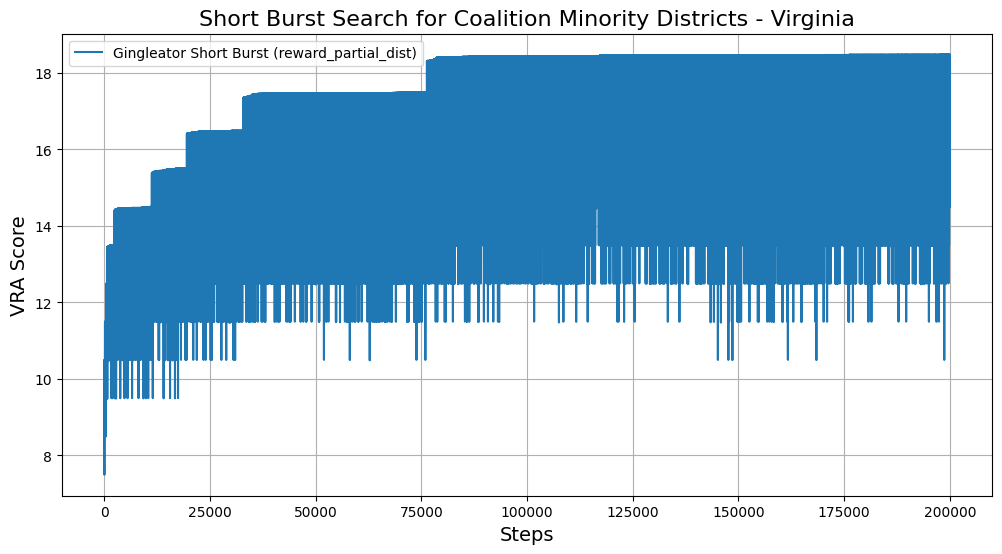

In [9]:
# Plot results
flattened_scores = observed_scores.flatten()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(flattened_scores, label="Gingleator Short Burst (reward_partial_dist)")
plt.xlabel("Steps", fontsize=14)
plt.ylabel("VRA Score", fontsize=14)
plt.title("Short Burst Search for Coalition Minority Districts - Virginia", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Print a final summary
print(f"\nFinal Max Score Achieved: {np.max(flattened_scores):.2f}")


Final Max Score Achieved: 18.48
